In [67]:
import numpy as np
import matplotlib
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize,
         'figure.facecolor': 'w'}
pylab.rcParams.update(params)
from matplotlib import pyplot as plt

import h5py
import corner

%load_ext autoreload
%autoreload 2
import plotter
import emulator

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Covariance of wp(rp) and the UPF

In [2]:
def covariance(arrs, zeromean=False):
    N = arrs.shape[0]

    if zeromean:
        w = arrs
    else:
        w = arrs - arrs.mean(0)

    outers = np.array([np.outer(w[n], w[n]) for n in range(N)])
    covsum = np.sum(outers, axis=0)
    cov = 1.0/float(N-1.0) * covsum
    return cov

In [3]:
# aka Correlation Matrix
def reduced_covariance(covmat):
    covmat = np.array(covmat)
    Nb = covmat.shape[0]
    reduced = np.zeros_like(covmat)
    for i in range(Nb):
        ci = covmat[i][i]
        for j in range(Nb):
            cj = covmat[j][j]
            reduced[i][j] = covmat[i][j]/np.sqrt(ci*cj)
    return reduced

In [4]:
# The prefactor unbiases the inverse; see e.g. Pearson 2016
def inverse_covariance(covmat, N):
    inv = np.linalg.inv(covmat)
    Nb = covmat.shape[0]
    prefac = float(N - Nb - 2)/float(N - 1)
    return prefac * inv

In [9]:
Nemu = 700
Ntest = 3500

In [59]:
statistics = ['wp','upf']
errtags = ['_hod3_test0','_hod3_test0']
stat_str = '_'.join(statistics)
err_str = ''.join(errtags)

res_dir = '../../clust/covariances/'

cov_aemulus = np.loadtxt(res_dir+"cov_aemulus_{}{}.dat".format(stat_str, err_str))
cov_aemulus *= 1./5.

In [37]:
cov_minerva = np.loadtxt(f'../../clust/results_minerva/{stat_str}_cov_minerva.dat')
cov_minerva *= 1./5. * (1.5/1.05)**3

In [15]:
statistics = ['wp','upf']
traintags = ['_nonolap', '_nonolap']
testtags = ['_mean_test0','_mean_test0']
errtags = ['_hod3_test0','_hod3_test0']
tags = ['_log_kM32ExpConst2_100hod','_log_kM32ExpConst_100hod']
acctags = []
for i, statistic in enumerate(statistics):
    gptag = traintags[i] + errtags[i] + tags[i]
    acctag = gptag + testtags[i]
    acctags.append(acctag)

stat_str = '_'.join(statistics)
acc_str = ''.join(acctags)

save_fn = f"../testing_results/{stat_str}_emu_cov{acc_str}.dat"
cov_emu = np.loadtxt(save_fn)

save_fn_perf = f"../testing_results/{stat_str}_emuperf_cov{acc_str}.dat"
cov_perf = np.loadtxt(save_fn_perf)

## Covariances 

The test covariance matrix has a large error in the highest-scale r-bin, because the measurements are more unstable at large scales (cosmic variance).

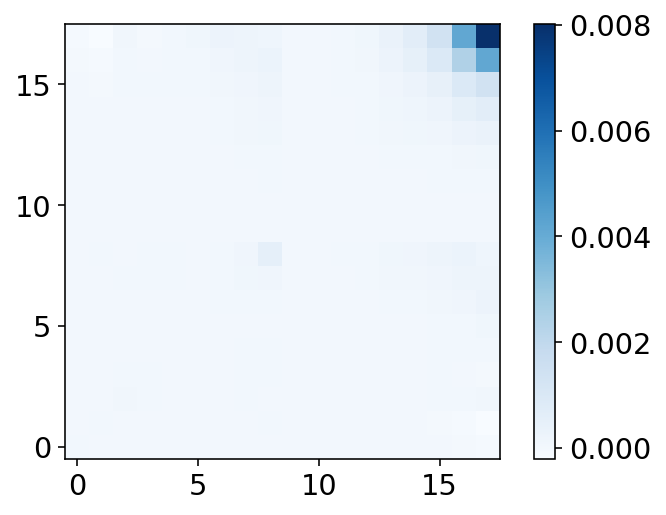

In [60]:
plt.imshow(cov_aemulus, origin='lower left', cmap='Blues')
plt.colorbar()

The Minerva covariance matrix measures the covariance between the statistic itself, not the errors. The statistics are all very consistent at the smallest-scale bin, and vary more at large scales. But these variations are much smaller than the ones in our test set, as Minerva is a fixed HOD and just varies the cosmology. (And maybe the cosmological parameter space is smaller than ours? Check this!)

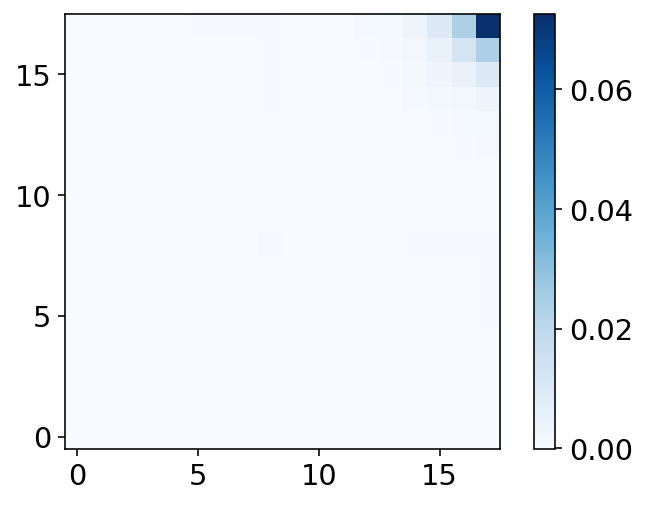

In [38]:
plt.imshow(cov_minerva, origin='lower left', cmap='Blues')
plt.colorbar()

The emulator covariance matrix should measure how good the emulator itself is, separate from the test set error. We see that it's also most uncertain at large scales. (Is this becaue the test set varies more at large scales? Or should it be independent? What else would it mean though?)

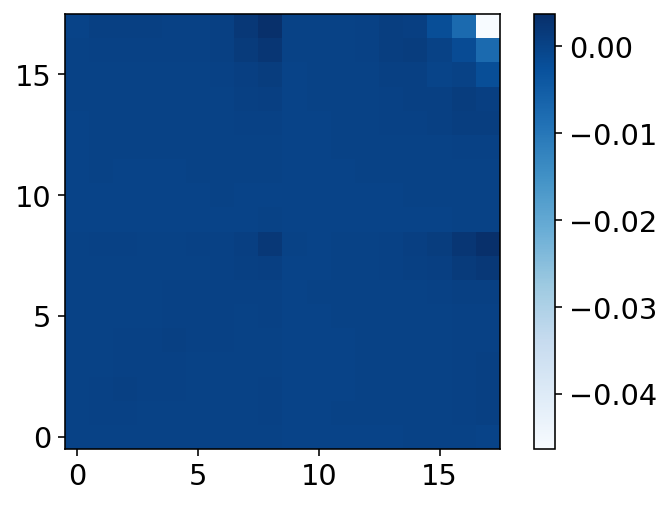

In [18]:
plt.imshow(cov_emu, origin='lower left', cmap='Blues')
plt.colorbar()

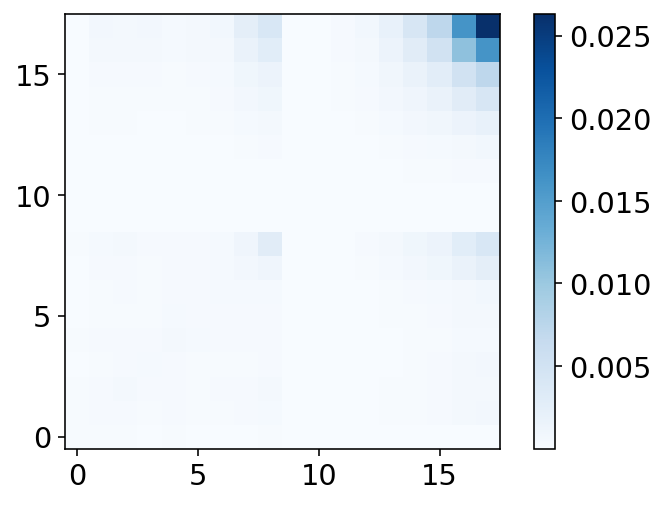

In [19]:
plt.imshow(cov_perf, origin='lower left', cmap='Blues')
plt.colorbar()

## Inverse covariance matrices

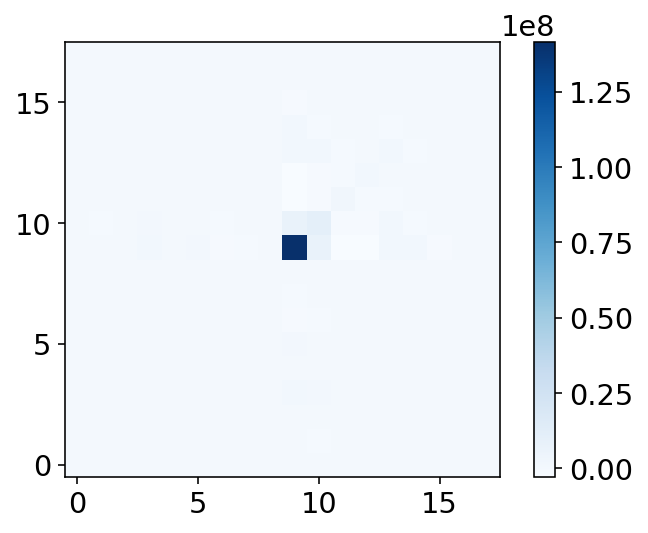

In [61]:
invcov_aemulus = inverse_covariance(cov_aemulus, Ntest)
plt.imshow(invcov_aemulus, origin='lower left', cmap='Blues')
plt.colorbar()

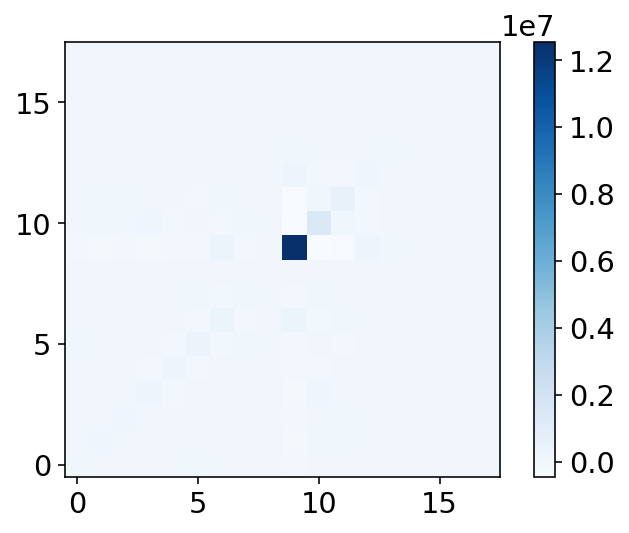

In [39]:
invcov_minerva = inverse_covariance(cov_minerva, Ntest)
plt.imshow(invcov_minerva, origin='lower left', cmap='Blues')
plt.colorbar()

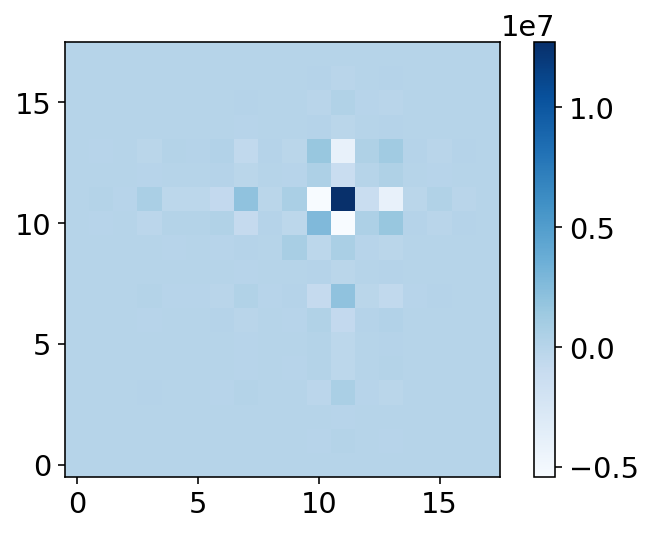

In [23]:
invcov_emu = inverse_covariance(cov_emu, Nemu)
plt.imshow(invcov_emu, origin='lower left', cmap='Blues')
plt.colorbar()

## Reduced covariance matrices (correlation matrices)

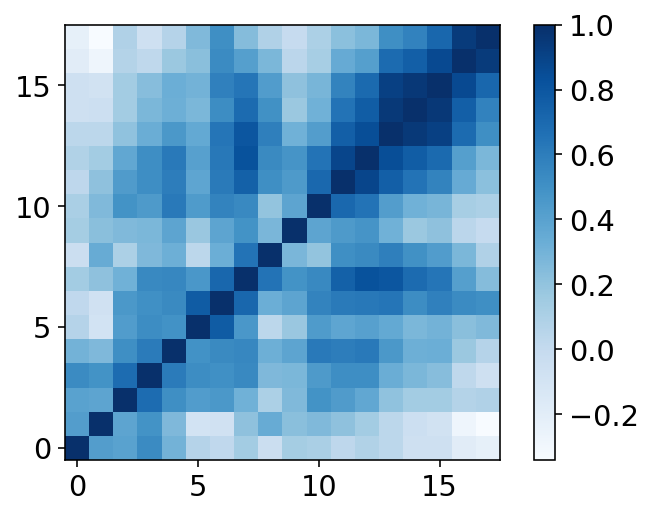

In [62]:
corr_aemulus = reduced_covariance(cov_aemulus)
plt.imshow(corr_aemulus, origin='lower left', cmap='Blues')
plt.colorbar()

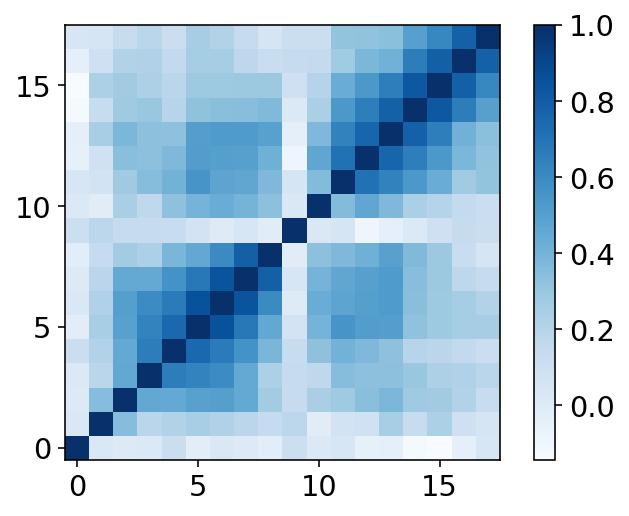

In [26]:
corr_minerva = reduced_covariance(cov_minerva)
plt.imshow(corr_minerva, origin='lower left', cmap='Blues')
plt.colorbar()

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in sqrt
  # Remove the CWD from sys.path while we load stuff.


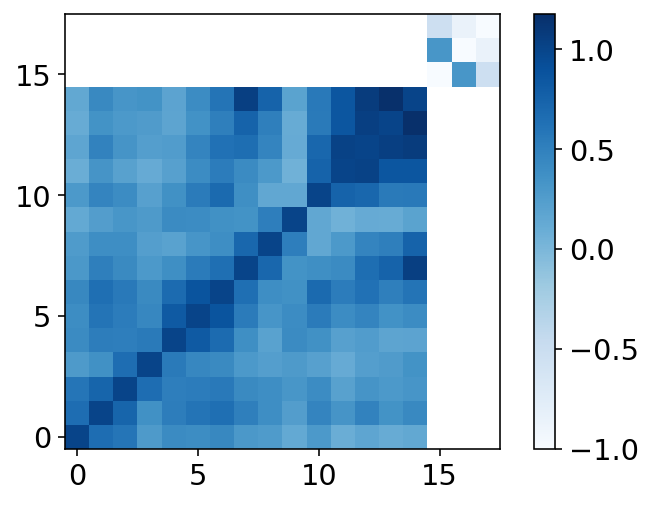

In [27]:
corr_emu = reduced_covariance(cov_emu)
plt.imshow(corr_emu, origin='lower left', cmap='Blues')
plt.colorbar()

## Diagonals

Let's check out the diagonals of these covariances - so, just the variances.

In [68]:
nbins = 9
rbin_edges_wp = np.logspace(np.log10(0.1), np.log10(50), nbins+1)
rbins_wp = 10**(0.5*(np.log10(rbin_edges)[:-1] + np.log10(rbin_edges)[1:]))
rbins_upf = np.linspace(5, 45, nbins)
rbins = {'wp': rbins_wp, 'upf': rbins_upf}

colors = ['blue', 'red', 'magenta', 'orange']
labels = ['Aemulus', 'Minerva', 'Emulator (Perf-Minerva)', 'Emu Performance']    

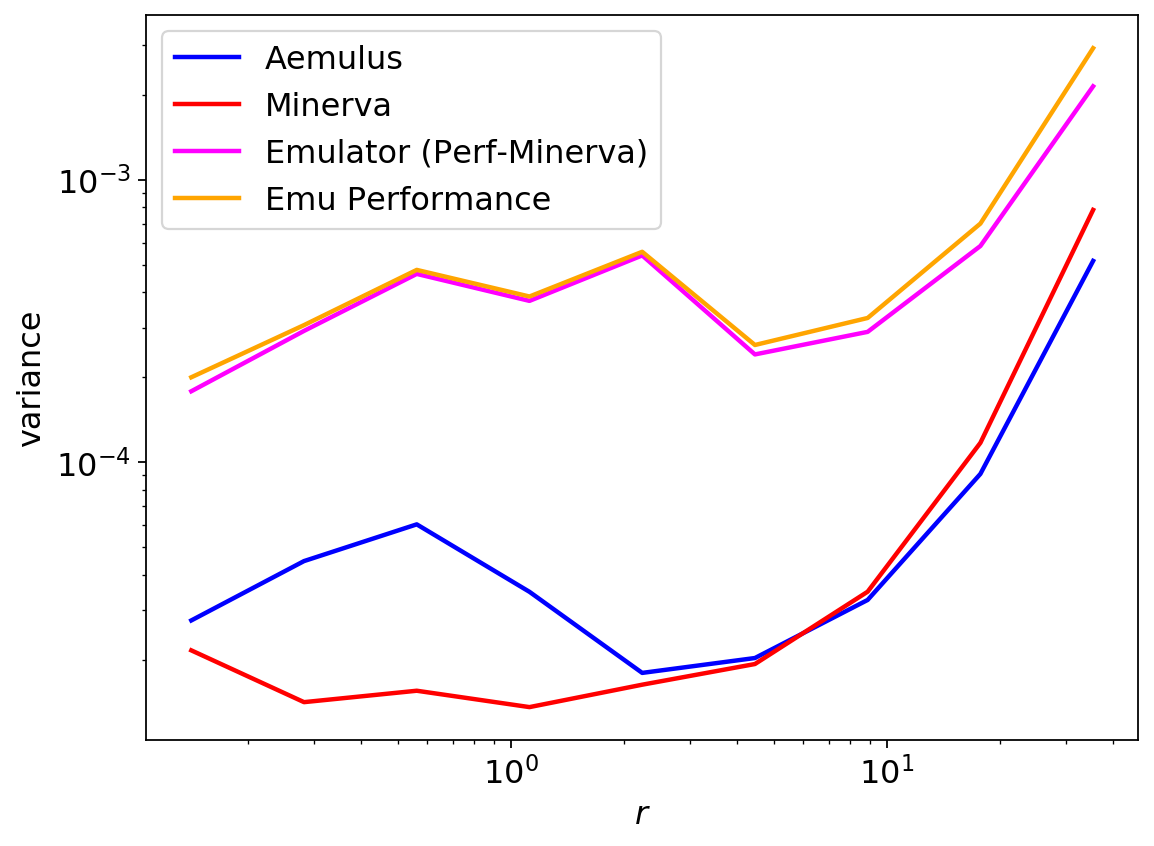

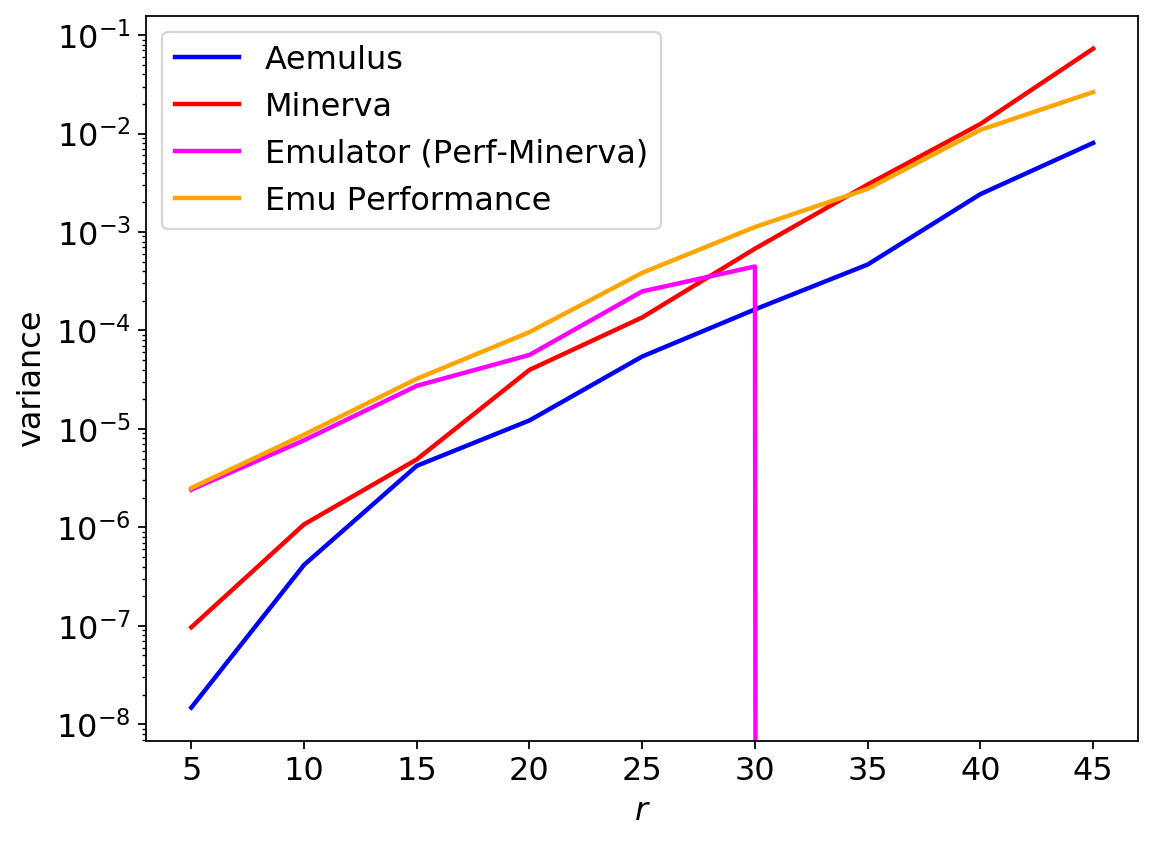

In [69]:
for s, statistic in enumerate(statistics):
    plt.figure(figsize=(8,6))
    start = s*nbins
    end = (s+1)*nbins
    var_aemulus = np.diag(cov_aemulus)[start:end]
    var_minerva = np.diag(cov_minerva)[start:end]
    var_emu = np.diag(cov_emu)[start:end]
    var_perf = np.diag(cov_perf)[start:end]
    variances = [var_aemulus, var_minerva, var_emu, var_perf]
    for i, var in enumerate(variances):
        plt.plot(rbins[statistic], var, color=colors[i], label=labels[i], lw=2)
    
    plt.xlabel(r"$r$")
    plt.ylabel("variance")
    if statistic=='wp':    
        plt.xscale("log")
    plt.yscale('log')
    plt.legend()

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


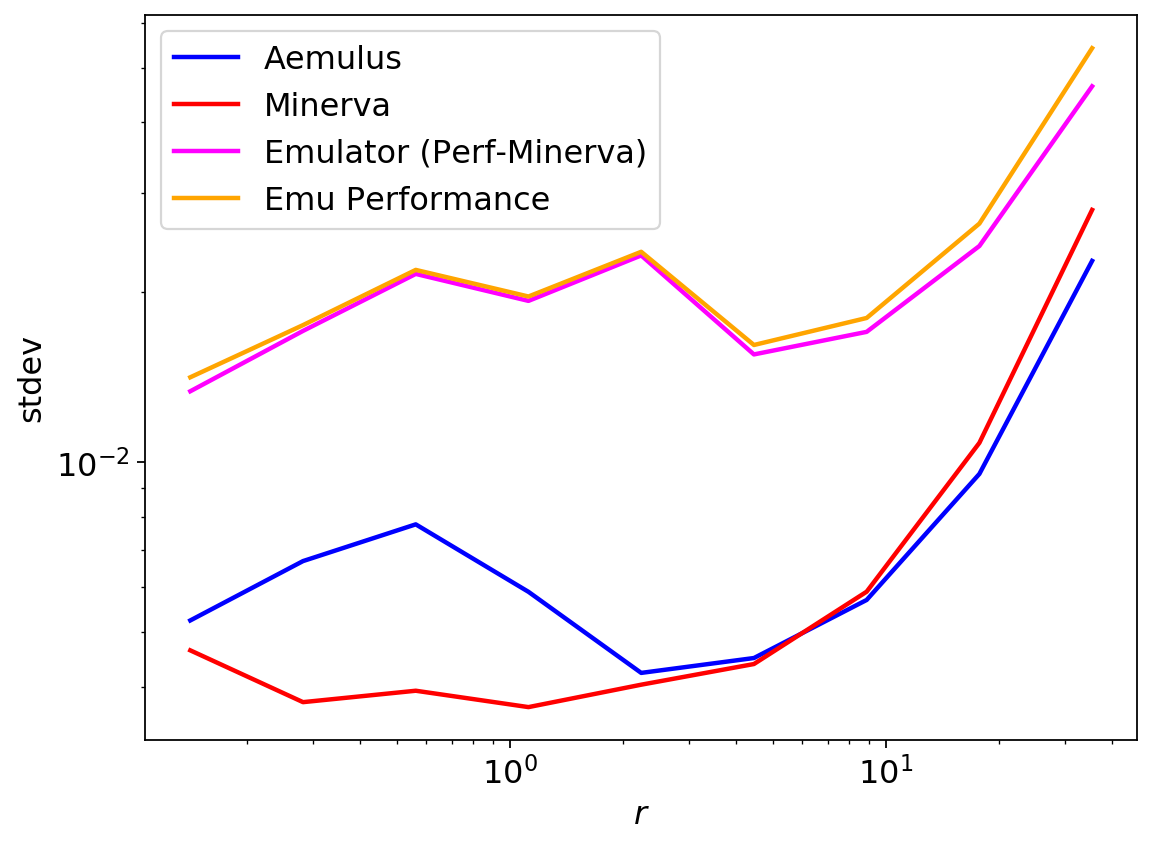

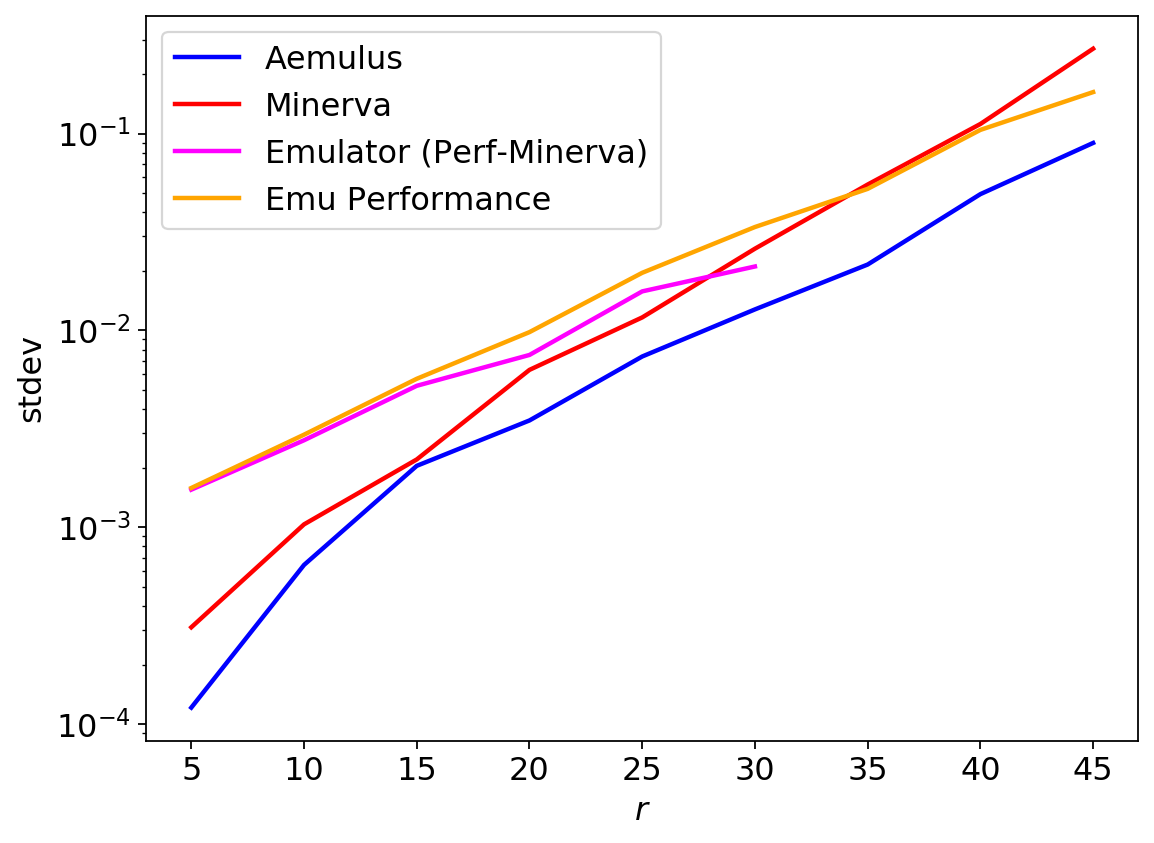

In [70]:
for s, statistic in enumerate(statistics):
    plt.figure(figsize=(8,6))
    start = s*nbins
    end = (s+1)*nbins
    var_aemulus = np.diag(cov_aemulus)[start:end]
    var_minerva = np.diag(cov_minerva)[start:end]
    var_emu = np.diag(cov_emu)[start:end]
    var_perf = np.diag(cov_perf)[start:end]
    variances = [var_aemulus, var_minerva, var_emu, var_perf]
    for i, var in enumerate(variances):
        plt.plot(rbins[statistic], np.sqrt(var), color=colors[i], label=labels[i], lw=2)
    
    plt.xlabel(r"$r$")
    plt.ylabel("stdev")
    if statistic=='wp':    
        plt.xscale("log")
    plt.yscale('log')
    plt.legend()